In [1]:
import os
# Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [2]:
import pandas as pd
import iris

from utils import get_aeronet_data, get_bc_ppe_data

from GCEm.utils import validation_plot, plot_parameter_space, get_random_params, ensemble_collocate
from GCEm.gp_model import GPModel
from GCEm.sampler import get_implausibility, constrain, batch_stats

import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline


C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


Basic structure:
 - Read and collocate some AeroNet data using CIS
 - emulate
 -- discuss AIC/BIC and kernel selection:
        from GCEm.utils import get_param_mask
        params = get_param_mask(X, model.flat_Y)
        model.train(X, params=params, **kwargs)
        This looks a useful summary: https://stats.stackexchange.com/questions/313887/why-isnt-akaike-information-criterion-used-more-in-machine-learning
 - validate
 - sample
 - constrain
 -- with and without batch implausibility (also show getting stats over the implausibility just using tf.reduce_mean(...))


# Read in the parameters and observables

In [3]:
# TODO: It would be nice to automate this somehow...
data_path = 'F:\\Local Data\\BC_PPE\\'

In [5]:
aaod = get_aeronet_data()
print(aaod)

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))


# Collocate the model on to the observations

In [6]:
col_ppe_aaod = ensemble_collocate(ppe_aaod, aaod)

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\numpy\ma\core.py:3188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\numpy\ma\core.py:3188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\numpy\ma\core.py:3188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

In [7]:
n_test = 8

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
Y_test, Y_train = col_ppe_aaod[:n_test], col_ppe_aaod[n_test:]

In [8]:
Y_train

Absorption Optical Thickness - Total 550Nm (1),job,obs
Shape,31,10098
Dimension coordinates,,
job,x,-
obs,-,x
Auxiliary coordinates,,
latitude,-,x
longitude,-,x
time,-,x


In [9]:
# TODO: Potentially Load ARI here

# Setup and run the models

In [10]:
model = GPModel(Y_train)

In [11]:
model.train(X_train)

In [12]:
m, v = model.predict(X_test.values)

Proportion of 'Bad' estimates : 0.81%


C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


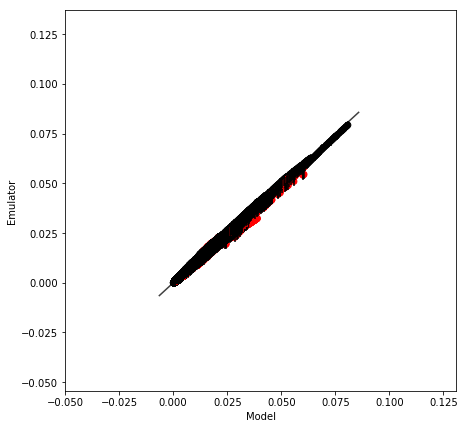

In [13]:
validation_plot(Y_test.data.flatten(), m.data.flatten(), v.data.flatten())


# Constrain the models

Emulating 1e6 sample points directly would require 673 Gb of memory so we can either run 1e6 samples for each point, or run the constraint everywhere, but in sample chunks. Here we do the latter (on the GPU) using the 'naive' algorithm for calculating the variance in batches

In [14]:
sample_points = pd.DataFrame(data=get_random_params(3, int(1e4)), columns=X_train.columns)

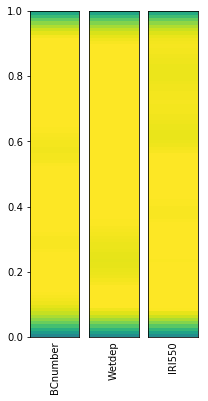

In [15]:
plot_parameter_space(sample_points, fig_size=(3,6))

In [16]:
implaus = get_implausibility(model, aaod, sample_points.values, batch_size=1000)

100%|##########| 10000/10000 [00:09<00:00, 1561.85sample/s]

In [17]:
implaus

Implausibility In Emulated Absorption Optical Thickness - Total 550Nm (1),sample,obs
Shape,10000,10098
Dimension coordinates,,
sample,x,-
obs,-,x
Auxiliary coordinates,,
latitude,-,x
longitude,-,x
time,-,x


[Text(0.5,0,'Implausibility')]

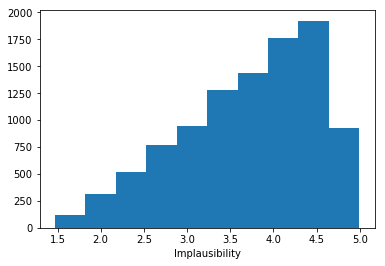

In [18]:
# It would be nice if this was easy...
# make_from_cube(implaus).as_data_frame()

_ = plt.hist(implaus.data[:, 14])
plt.gca().set(xlabel='Implausibility')

In [19]:
valid_samples = constrain(implaus.data, tolerance=.5).numpy()

Remaining points: 1091


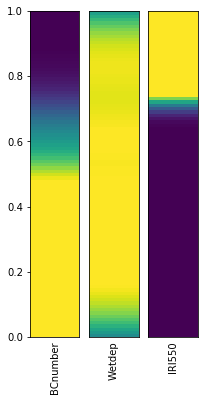

In [20]:
print("Remaining points: {}".format(valid_samples.sum()))

constrained_sample = sample_points[valid_samples]
plot_parameter_space(constrained_sample, fig_size=(3,6))

# TODO: Turn this into DRE

In [21]:
Y_test, Y_train = ppe_aaod[:n_test], ppe_aaod[n_test:]

ari_model = GPModel(Y_train.collapsed('time', iris.analysis.MEAN), "ARI")
ari_model.train(X_train)

In [22]:
unconstrained_mean_ari, unconstrained_sd_ari = batch_stats(ari_model, sample_points, batch_size=100)
constrained_mean_ari, constrained_sd_ari = batch_stats(ari_model, constrained_sample, batch_size=100)

1100sample [00:01, 93.57sample/s]<00:00, 93.57sample/s]/s]

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


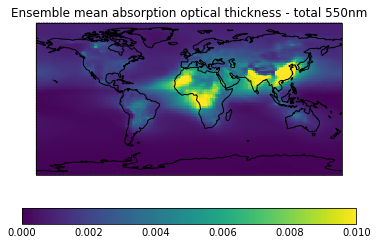

In [23]:
qplt.pcolormesh(unconstrained_mean_ari, vmin=0., vmax=1e-2)
plt.gca().coastlines()

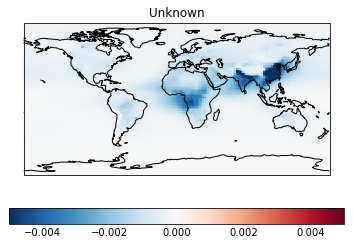

In [24]:
# The change in spread after the constraint is applied
qplt.pcolormesh((constrained_sd_ari-unconstrained_sd_ari), cmap='RdBu_r', vmin=-5e-3, vmax=5e-3)
plt.gca().coastlines()